# Simulation of Vessel Trajectories & Anomalies

**TODOs**

- [ ] Get start orientation of vessels from port?
- [ ] Get speed based on route? 
- [x] Save simulated trajectories to file
- [ ] Add anomalies
    - [ ] Add speed anomalies
        - [x] Basic speed anomalies
    - [ ] Add location anomalies (i.e. vessels ignore obstacles)
    - [ ] Add direction anomalies? 
- [ ] Create export for M³ training, incl. MMSI, T, LAT, LON, SOG, COG, vessel type? 

In [28]:
import pandas as pd
import movingpandas as mpd
from datetime import datetime, timedelta

from model import ShipModel

MAX_STEPS = 1000
N_SHIPS = 2

ports = [(11,10), (30,30),(70,50),(10,70),(70,20), (90,89)]
obstacles = [(99,99),(10,0),(6,60),(45,24),(20,18),(60,85),(40,15),(60,40),(69,30)]
model = ShipModel(population=N_SHIPS, vision=20, avoidance=1.1, ports=ports, obstacles=obstacles)
for type, agents in model.agents_by_type.items():
    print(f'{type}: {len(agents)}')


Setting starting port to [90 89] ...
Setting destination port to (70, 50) ...
Setting max speed to 1.4593165722219148 ...
Setting starting port to [70 20] ...
Setting destination port to (30, 30) ...
Setting max speed to 1.154222378693633 ...
<class 'ship.Ship'>: 2
<class 'obstacle.Obstacle'>: 9


## Trajectory Simulation

In [4]:
print(f"{datetime.now()} Starting ...")
for t in range(MAX_STEPS):
    stride = 20
    if t%stride == 0:
        print(f"Step {t} ...")
    model.step()
print(f"{datetime.now()} Finished.")

2025-02-19 10:59:18.103652 Starting ...
Step 0 ...
Step 1 ...
Step 2 ...
Step 3 ...
Step 4 ...
Step 5 ...
Step 6 ...
Step 7 ...
Step 8 ...
Step 9 ...
Step 10 ...
Step 11 ...
Step 12 ...
Step 13 ...
Step 14 ...
Step 15 ...
Step 16 ...
Step 17 ...
Step 18 ...
Step 19 ...
Step 20 ...
Step 21 ...
Step 22 ...
Step 23 ...
Step 24 ...
Step 25 ...
Step 26 ...
Step 27 ...
Step 28 ...
Step 29 ...
Step 30 ...
Step 31 ...
Step 32 ...
Step 33 ...
Step 34 ...
Step 35 ...
Step 36 ...
Step 37 ...
Step 38 ...
Step 39 ...
Step 40 ...
Step 41 ...
Step 42 ...
Step 43 ...
Step 44 ...
Step 45 ...
Step 46 ...
Step 47 ...
Step 48 ...
Step 49 ...
Step 50 ...
Step 51 ...
Step 52 ...
Step 53 ...
Step 54 ...
Step 55 ...
Step 56 ...
Step 57 ...
Step 58 ...
Step 59 ...
Step 60 ...
Step 61 ...
Step 62 ...
Step 63 ...
Step 64 ...
Step 65 ...
Step 66 ...
Step 67 ...
Step 68 ...
Step 69 ...
Step 70 ...
Step 71 ...
Step 72 ...
Step 73 ...
Step 74 ...
Step 75 ...
Step 76 ...
Step 77 ...
Step 78 ...
Step 79 ...
Step 80 ..

20 vessels x 1000 steps ... > 1h

In [5]:
agent_df = model.datacollector.get_agent_vars_dataframe()

In [22]:
df = agent_df.reset_index()
df[['x', 'y']] = pd.DataFrame(df['pos'].tolist(), index=df.index)
df = df.drop(columns=['pos'])
df = df[df.AgentID<=N_SHIPS] # removes obstacles
df

,Step,AgentID,x,y
0,0,1,10.000000,70.000000
1,0,2,11.000000,10.000000
11,1,1,10.017604,70.007148
12,1,2,11.017504,10.007390
22,2,1,10.044623,70.017683
...,...,...,...,...
10979,998,2,69.946600,50.016248
10989,999,1,30.031930,30.034141
10990,999,2,69.947428,50.015687
11000,1000,1,30.034622,30.035465


In [24]:
start_datetime = datetime.now()
df["t"] = df["Step"].apply(lambda step: start_datetime + timedelta(seconds=step))

In [ ]:
tc = mpd.TrajectoryCollection(df, traj_id_col='AgentID', t='t', x='x', y='y', crs=31287)

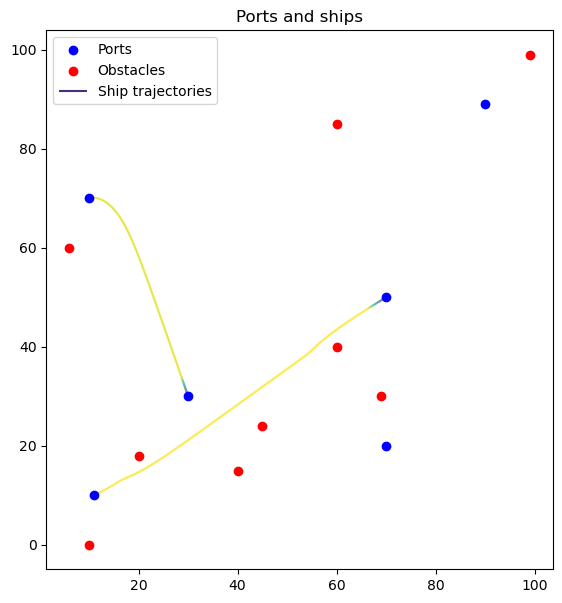

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7,7))

x_coords, y_coords = zip(*ports)
ax.scatter(x_coords, y_coords, color='blue', label='Ports', zorder=5)
x_coords, y_coords = zip(*obstacles)
ax.scatter(x_coords, y_coords, color='red', label='Obstacles', zorder=5)
tc.plot(ax=ax, label='Ship trajectories', column='speed')

# Labels and legend
ax.legend()
ax.set_title("Ports and ships")

plt.show()

In [147]:
tc.add_speed(overwrite=True)
tc.trajectories[0].df#.hvplot(c='speed')

,Step,AgentID,geometry,speed
t,,,,
2025-02-19 11:34:29.514207,0,1,POINT (10 70),0.019
2025-02-19 11:34:30.514207,1,1,POINT (10.018 70.007),0.019
2025-02-19 11:34:31.514207,2,1,POINT (10.045 70.018),0.029
2025-02-19 11:34:32.514207,3,1,POINT (10.08 70.031),0.038
2025-02-19 11:34:33.514207,4,1,POINT (10.125 70.046),0.047
...,...,...,...,...
2025-02-19 11:51:05.514207,996,1,POINT (30.024 30.03),0.003
2025-02-19 11:51:06.514207,997,1,POINT (30.027 30.031),0.003
2025-02-19 11:51:07.514207,998,1,POINT (30.029 30.033),0.003


In [148]:
sim_result = tc.to_point_gdf()
sim_result['x'] = sim_result.geometry.x
sim_result['y'] = sim_result.geometry.y
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
sim_out_file_name = f'sim_{timestamp}.csv'
sim_result.to_csv(sim_out_file_name)
print(f'Saved simulation results to {sim_out_file_name}')

Saved simulation results to sim_20250219_125547.csv


## Anomaly Simulation

In [ ]:
import numpy as np
import pandas as pd
import movingpandas as mpd
from datetime import datetime, timedelta

In [3]:
sim_out_file_name = 'sim_20250219_125547.csv'

In [37]:
sims = pd.read_csv(sim_out_file_name)
tc = mpd.TrajectoryCollection(sims, t='t', traj_id_col='AgentID', x='x', y='y', crs=31287)
tc

TrajectoryCollection with 2 trajectories

In [38]:
# Remove stopped segments (with speed < 0.01)
tc = mpd.SpeedSplitter(tc).split(speed=0.01, duration=timedelta(seconds=5))

### Speed

In [39]:
def inject_speed_anomaly(traj, duration_pct=(0.1,0.2), speedup_pct=(1.5,2.5)):
    df = traj.df.copy()
    df.reset_index(inplace=True)
    df["t_diff"] = df['t'].diff()
    # Choose within middle range
    total_steps = len(df)
    anomaly_start_idx = np.random.randint(0.1 * total_steps, 0.7 * total_steps)  
    duration_pct = duration_pct[0] + (np.random.random() * (duration_pct[1]-duration_pct[0]))
    anomaly_duration = int(duration_pct * total_steps)  
    # Insert new values
    speedup_pct = speedup_pct[0] + (np.random.random() * (speedup_pct[1]-speedup_pct[0]))
    new_vals = df.iloc[anomaly_start_idx : anomaly_start_idx + anomaly_duration].t_diff / speedup_pct
    df.loc[anomaly_start_idx : anomaly_start_idx + anomaly_duration -1, "t_diff"] = new_vals
    # Flag anomalies
    df['is_anomaly'] = False
    df.loc[anomaly_start_idx : anomaly_start_idx + anomaly_duration -1, "is_anomaly"] = True
    # Correct the timestamp update logic
    df["t"] = df["t"].iloc[0] + df["t_diff"].fillna(pd.Timedelta(seconds=0)).cumsum()
    return mpd.Trajectory(df,t='t',traj_id=traj.id)


<Axes: >

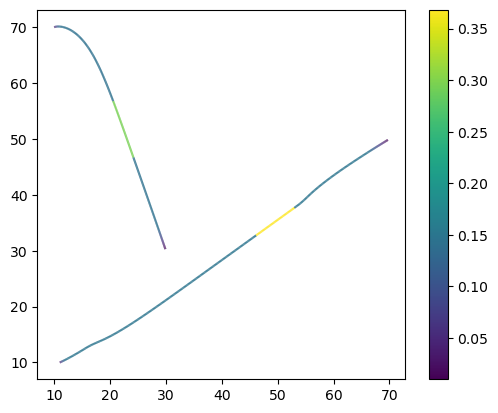

In [40]:
for i, traj in enumerate(tc.trajectories):
    traj = inject_speed_anomaly(traj)
    tc.trajectories[i] = traj
    
tc.add_speed(overwrite=True)
tc.plot(column='speed', legend=True)

### Location

### Direction

## Export for M³ / M³fed